In [32]:
import numpy as np

In [33]:
import pandas as pd

# Load ratings
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id','movie_id','rating','timestamp'])
print(ratings.head())

# Load users
users = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id','age','gender','occupation','zip_code'])
print(users.head())

# Load movies
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', usecols=range(5), 
                     names=['movie_id','title','release_date','video_release_date','IMDb_URL'])
print(movies.head())


   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  
0  http://us.imdb.com/M/title-exact?To

In [34]:
import matplotlib.pyplot as plt
import networkx as nx


In [35]:
def plot_rating_distribution(ratings):
    plt.figure(figsize=(6, 4))
    ratings['rating'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.title("Rating Distribution (MovieLens 100K)")
    plt.tight_layout()
    plt.show()


In [36]:
def plot_degree_distributions(train_ratings, num_users, num_movies):
    user_degree = train_ratings['user_idx'].value_counts()
    movie_degree = train_ratings['movie_idx'].value_counts()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(user_degree, bins=50, log=True)
    plt.xlabel("User Degree (#ratings)")
    plt.ylabel("Count (log)")
    plt.title("User Degree Distribution")

    plt.subplot(1, 2, 2)
    plt.hist(movie_degree, bins=50, log=True)
    plt.xlabel("Movie Degree (#ratings)")
    plt.ylabel("Count (log)")
    plt.title("Movie Degree Distribution")

    plt.tight_layout()
    plt.show()


In [37]:
def plot_sample_bipartite_graph(train_ratings, num_users, sample_users=20):
    sampled_users = np.random.choice(train_ratings['user_idx'].unique(),
                                      sample_users, replace=False)
    sample_df = train_ratings[train_ratings['user_idx'].isin(sampled_users)]

    G = nx.Graph()

    for _, row in sample_df.iterrows():
        u = f"U{row['user_idx']}"
        m = f"M{row['movie_idx'] - num_users}"
        G.add_edge(u, m)

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos,
        node_size=200,
        with_labels=False,
        node_color=[
            'skyblue' if n.startswith('U') else 'lightcoral'
            for n in G.nodes()
        ]
    )
    plt.title("Sample User-Movie Bipartite Graph")
    plt.show()


In [38]:


GENRE_COLS = [f"genre_{i}" for i in range(19)]


import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import os

def load_movielens_data():
    print("📚 Loading MovieLens 100K data...")
    
    ratings = pd.read_csv(
        'ml-100k/u.data',
        sep='\t',
        names=['user_id', 'movie_id', 'rating', 'timestamp']
    )

    users = pd.read_csv(
        'ml-100k/u.user',
        sep='|',
        names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
    )

    movies_meta = pd.read_csv(
        'ml-100k/u.item',
        sep='|',
        encoding='latin-1',
        usecols=range(5),
        names=['movie_id', 'title', 'release_date',
               'video_release_date', 'IMDb_URL']
    )

    movie_genres = pd.read_csv(
        'ml-100k/u.item',
        sep='|',
        encoding='latin-1',
        usecols=range(5, 24),
        header=None,
        names=GENRE_COLS
    )

    movies = pd.concat([movies_meta[['movie_id']], movie_genres], axis=1)

    print(f"  Ratings: {len(ratings)}")
    print(f"  Users: {len(users)}")
    print(f"  Movies: {len(movies)}")

    return ratings, users, movies


def create_user_features(users):
    """
    Create user feature matrix
    Features: age (normalized), gender (one-hot), occupation (one-hot)
    """
    print("\n🔧 Creating user features...")
    
    user_features = []
    
    # Encode gender
    gender_encoder = LabelEncoder()
    gender_encoded = gender_encoder.fit_transform(users['gender'])
    
    # Encode occupation
    occupation_encoder = LabelEncoder()
    occupation_encoded = occupation_encoder.fit_transform(users['occupation'])
    num_occupations = len(occupation_encoder.classes_)
    
    for idx, user in users.iterrows():
        feat = []
        
        # Age (normalized to 0-1)
        feat.append(user['age'] / 100.0)
        
        # Gender (binary)
        feat.append(gender_encoded[idx])
        
        # Occupation (one-hot)
        occ_onehot = [0] * num_occupations
        occ_onehot[occupation_encoded[idx]] = 1
        feat.extend(occ_onehot)
        
        user_features.append(feat)
    
    user_features = torch.tensor(user_features, dtype=torch.float)
    print(f"  User feature shape: {user_features.shape}")
    
    return user_features, {
        'gender_encoder': gender_encoder,
        'occupation_encoder': occupation_encoder,
        'num_occupations': num_occupations
    }

def create_movie_features(movies):
    """
    Create movie feature matrix
    Features: 19 binary genre indicators
    """
    print("\n🎬 Creating movie features...")
    
    movie_features = torch.tensor(
        movies[GENRE_COLS].values,
        dtype=torch.float
    )

    print(f"  Movie feature shape: {movie_features.shape}")
    return movie_features


def create_bipartite_graph(ratings, num_users, num_movies, test_size=0.2, cold_start_threshold=5):
    """
    Create bipartite graph with cold start problem setup
    
    Cold start users/movies (with <= cold_start_threshold ratings) are placed in test set
    
    Node indexing:
    - Users: 0 to num_users-1
    - Movies: num_users to num_users+num_movies-1
    """
    print("\n🕸️ Creating bipartite graph with cold start problem...")
    
    # Convert to 0-indexed
    ratings = ratings.copy()
    ratings['user_idx'] = ratings['user_id'] - 1  # Users: 0 to 942
    ratings['movie_idx'] = ratings['movie_id'] - 1 + num_users  # Movies: 943 to 2624
    
    # Identify cold start users and movies
    user_counts = ratings['user_id'].value_counts()
    movie_counts = ratings['movie_id'].value_counts()
    
    cold_start_users = set(user_counts[user_counts <= cold_start_threshold].index)
    cold_start_movies = set(movie_counts[movie_counts <= cold_start_threshold].index)
    
    print(f"\n  ❄️  Cold Start Analysis (threshold: {cold_start_threshold} ratings):")
    print(f"     Cold start users: {len(cold_start_users)} / {num_users} ({len(cold_start_users)/num_users*100:.1f}%)")
    print(f"     Cold start movies: {len(cold_start_movies)} / {num_movies} ({len(cold_start_movies)/num_movies*100:.1f}%)")
    
    # Mark ratings as cold start if they involve cold start users or movies
    ratings['is_cold_start'] = ratings.apply(
        lambda row: (row['user_id'] in cold_start_users) or (row['movie_id'] in cold_start_movies),
        axis=1
    )
    
    cold_start_ratings = ratings[ratings['is_cold_start']]
    warm_start_ratings = ratings[~ratings['is_cold_start']]
    
    print(f"     Cold start ratings: {len(cold_start_ratings)} / {len(ratings)} ({len(cold_start_ratings)/len(ratings)*100:.1f}%)")
    print(f"     Warm start ratings: {len(warm_start_ratings)} / {len(ratings)} ({len(warm_start_ratings)/len(ratings)*100:.1f}%)")
    
    # Split warm start data for train/test (with stratification)
    num_warm_test = max(1, int(len(warm_start_ratings) * test_size))
    train_warm, test_warm = train_test_split(
        warm_start_ratings,
        test_size=num_warm_test,
        random_state=42,
        stratify=warm_start_ratings['rating'].apply(lambda x: int(x))
    )
    
    # Put all cold start ratings in test set
    test_ratings = pd.concat([test_warm, cold_start_ratings], ignore_index=True)
    train_ratings = train_warm
    
    print(f"\n  Train ratings: {len(train_ratings)}")
    print(f"  Test ratings: {len(test_ratings)}")
    
    # Create edge list for training (bidirectional for message passing)
    train_edges = []
    train_edge_attrs = []
    
    for _, row in train_ratings.iterrows():
        user_idx = int(row['user_idx'])
        movie_idx = int(row['movie_idx'])
        rating = row['rating']
        
        # User -> Movie
        train_edges.append([user_idx, movie_idx])
        train_edge_attrs.append(rating)
        
        # Movie -> User (bidirectional)
        train_edges.append([movie_idx, user_idx])
        train_edge_attrs.append(rating)
    
    train_edge_index = torch.tensor(train_edges, dtype=torch.long).t()
    train_edge_attr = torch.tensor(train_edge_attrs, dtype=torch.float).unsqueeze(1)
    
    print(f"  Train edge_index shape: {train_edge_index.shape}")
    print(f"  Train edge_attr shape: {train_edge_attr.shape}")
    
    return train_edge_index, train_edge_attr, train_ratings, test_ratings

def create_dataset():
    """
    Main function to create competition dataset
    """
    print("=" * 60)
    print("🎯 CREATING MOVIELENS GNN COMPETITION DATASET")
    print("=" * 60)
    
    # Load data
    ratings, users, movies = load_movielens_data()
    
    num_users = len(users)
    num_movies = len(movies)
    num_nodes = num_users + num_movies
    
    print(f"\n📊 Dataset Statistics:")
    print(f"  Users: {num_users}")
    print(f"  Movies: {num_movies}")
    print(f"  Total nodes: {num_nodes}")
    print(f"  Total ratings: {len(ratings)}")
    print(f"  Rating range: {ratings['rating'].min()}-{ratings['rating'].max()}")
    print(f"  Sparsity: {len(ratings)/(num_users*num_movies)*100:.2f}%")
    
    # Create features
    user_features, user_encoders = create_user_features(users)
    movie_features = create_movie_features(movies)
    
    # Pad features to same dimension
    max_dim = max(user_features.shape[1], movie_features.shape[1])
    
    if user_features.shape[1] < max_dim:
        padding = torch.zeros(user_features.shape[0], max_dim - user_features.shape[1])
        user_features = torch.cat([user_features, padding], dim=1)
    
    if movie_features.shape[1] < max_dim:
        padding = torch.zeros(movie_features.shape[0], max_dim - movie_features.shape[1])
        movie_features = torch.cat([movie_features, padding], dim=1)
    
    # Combine features
    x = torch.cat([user_features, movie_features], dim=0)
    print(f"\n✅ Combined feature matrix shape: {x.shape}")

    # Create bipartite graph
    train_edge_index, train_edge_attr, train_ratings, test_ratings = create_bipartite_graph(
        ratings, num_users, num_movies
    )
    
    # Create node type mask (0=user, 1=movie)
    node_type = torch.zeros(num_nodes, dtype=torch.long)
    node_type[num_users:] = 1
    
    # Save processed data
    print("\n💾 Saving dataset...")
    os.makedirs('../data', exist_ok=True)
    
    # Save graph structure
    torch.save({
        'x': x,
        'edge_index': train_edge_index,
        'edge_attr': train_edge_attr,
        'node_type': node_type,
        'num_users': num_users,
        'num_movies': num_movies,
        'num_nodes': num_nodes,
        'num_features': x.shape[1]
    }, '../data/graph_data.pt')
    
    # Save train/test splits
    train_ratings[['user_id', 'movie_id', 'rating']].to_csv(
        '../data/train_ratings.csv', index=False
    )
    
    test_ratings[['user_id', 'movie_id']].to_csv(
        '../data/test_pairs.csv', index=False
    )
    
    # Hidden test labels (for scoring)
    test_ratings[['user_id', 'movie_id', 'rating']].to_csv(
        '../data/test_ratings_hidden.csv', index=False
    )
    
    # Sample submission
    sample_submission = test_ratings[['user_id', 'movie_id']].copy()
    sample_submission['rating'] = 3.0  # Average rating
    os.makedirs('../submissions', exist_ok=True)
    sample_submission.to_csv('../submissions/sample_submission.csv', index=False)
    
    # Save metadata
    metadata = {
        'num_users': num_users,
        'num_movies': num_movies,
        'num_nodes': num_nodes,
        'num_features': x.shape[1],
        'num_train_ratings': len(train_ratings),
        'num_test_ratings': len(test_ratings),
        'rating_min': float(ratings['rating'].min()),
        'rating_max': float(ratings['rating'].max()),
        'user_feature_dim': user_features.shape[1],
        'movie_feature_dim': movie_features.shape[1],
        'genre_cols': GENRE_COLS,
        'user_encoders': user_encoders
    }
    
    with open('../data/metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    
    print("\n✅ Dataset created successfully!")
    print("\n📁 Files created:")
    print("  ├── data/graph_data.pt")
    print("  ├── data/train_ratings.csv")
    print("  ├── data/test_pairs.csv")
    print("  ├── data/test_ratings_hidden.csv")
    print("  ├── data/metadata.pkl")
    print("  └── submissions/sample_submission.csv")
    
    # Print statistics
    print("\n📈 Rating Distribution:")
    for rating in sorted(ratings['rating'].unique()):
        count = (ratings['rating'] == rating).sum()
        pct = count / len(ratings) * 100
        print(f"  {int(rating)}⭐: {count:5d} ({pct:5.2f}%)")
    
    plot_rating_distribution(train_ratings)
    plot_degree_distributions(train_ratings, num_users, num_movies)
    plot_sample_bipartite_graph(train_ratings, num_users)

    print("\n" + "=" * 60)
    print("🎉 READY TO BUILD YOUR GNN!")
    print("=" * 60)

🎯 CREATING MOVIELENS GNN COMPETITION DATASET
📚 Loading MovieLens 100K data...
  Ratings: 100000
  Users: 943
  Movies: 1682

📊 Dataset Statistics:
  Users: 943
  Movies: 1682
  Total nodes: 2625
  Total ratings: 100000
  Rating range: 1-5
  Sparsity: 6.30%

🔧 Creating user features...
  User feature shape: torch.Size([943, 23])

🎬 Creating movie features...
  Movie feature shape: torch.Size([1682, 19])

✅ Combined feature matrix shape: torch.Size([2625, 23])

🕸️ Creating bipartite graph with cold start problem...

  ❄️  Cold Start Analysis (threshold: 5 ratings):
     Cold start users: 0 / 943 (0.0%)
     Cold start movies: 384 / 1682 (22.8%)
     Cold start ratings: 968 / 100000 (1.0%)
     Warm start ratings: 99032 / 100000 (99.0%)

  Train ratings: 79226
  Test ratings: 20774
  Train edge_index shape: torch.Size([2, 158452])
  Train edge_attr shape: torch.Size([158452, 1])

💾 Saving dataset...

✅ Dataset created successfully!

📁 Files created:
  ├── data/graph_data.pt
  ├── data/tra

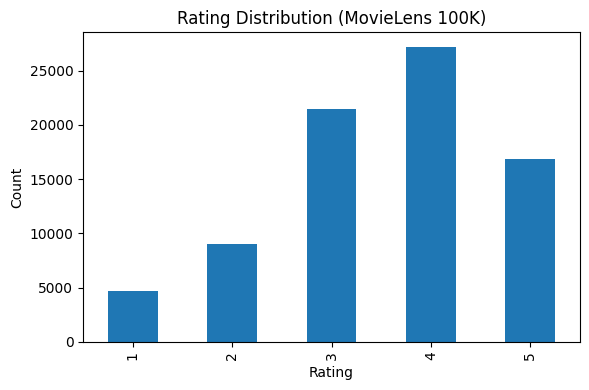

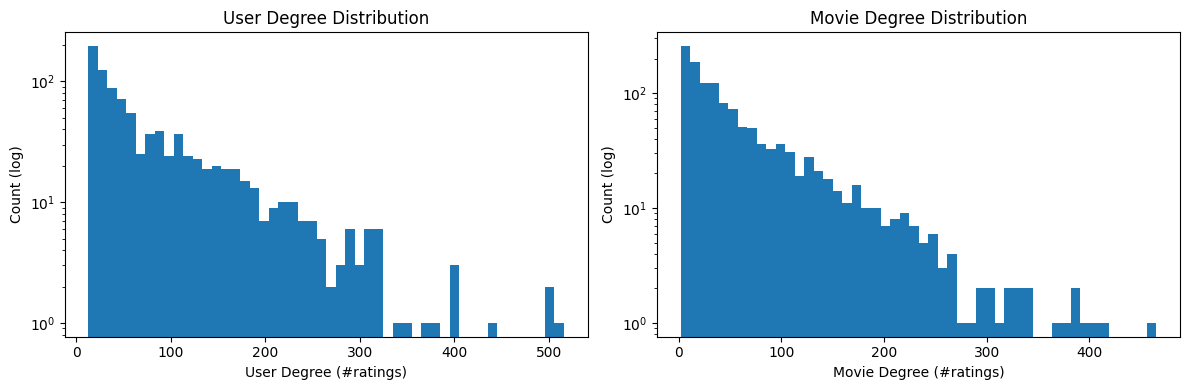

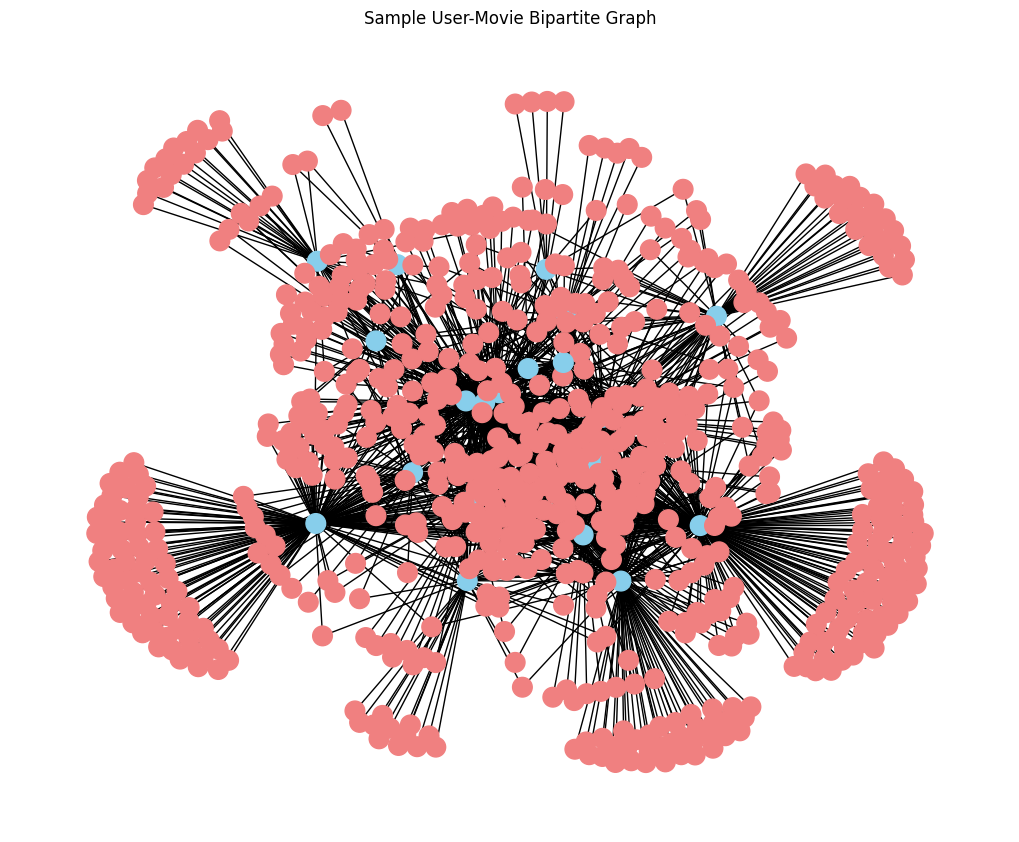


🎉 READY TO BUILD YOUR GNN!


In [39]:
if __name__ == "__main__":
    create_dataset()